In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mhcflurry import predict
from sklearn.metrics import confusion_matrix, accuracy_score

Using TensorFlow backend.
/home/vasily/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
filepath = "./data/immunogenic_peptides.txt"
if os.path.isfile(filepath):
    df = pd.read_csv(filepath, sep="\t")
    print("Reading {}".format(os.path.basename(filepath)))
else:
    print("File path is wrong")

Reading immunogenic_peptides.txt


In [3]:
df.head(2)

,Peptide,MHC,Species,Immunogenicity
0,AAFDRKSDAK,HLA-A1101,Homo,immunogenic
1,AAFEFINSL,H-2-Kb,Mus,immunogenic


In [4]:
df["Immunogenicity"].value_counts()

immunogenic        2167
non-immunogenic     341
Name: Immunogenicity, dtype: int64

In [5]:
predict(alleles=df["MHC"].iloc[0:1], peptides=df["Peptide"].iloc[0:10]).head(2)

/home/vasily/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gradients.py:90: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


,Allele,Peptide,Prediction
0,HLA-A1101,AAFDRKSDAK,367.609009
1,HLA-A1101,AAFEFINSL,6281.542969


In [8]:
predictions = pd.DataFrame()
warning = pd.DataFrame()
warnings = 0
warning_loc = []
for i in range(len(df)):
    try:
        prediction = predict(alleles=df["MHC"].iloc[i:i+1].reset_index(drop=True),
                                   peptides=df["Peptide"].iloc[i:i+1].reset_index(drop=True))
        frame = [predictions, prediction]
        predictions = pd.concat(frame)
    except ValueError:
        warnings += 1
        frame = [warning, df.iloc[i]]
        warning = pd.concat(frame)
        warning_loc.append(i)
if len(predictions):
    print("Predictions made")
else:
    print("Something went wrong")
print("Number of warnings is {}".format(warnings))
print(warning)

Predictions made
Number of warnings is 1
                          0
Peptide           NIRQAGVQY
MHC               HLA-B1502
Species                Homo
Immunogenicity  immunogenic


In [9]:
predictions.head(2)

,Allele,Peptide,Prediction
0,HLA-A1101,AAFDRKSDAK,367.609009
0,H-2-KB,AAFEFINSL,4.883403


In [10]:
def coding(col, codeDict):
    colCoded = pd.Series(col, copy=True)
    for key, value in codeDict.items():
        colCoded.replace(key, value, inplace=True)
    return colCoded

In [11]:
true_values = coding(df["Immunogenicity"], {"immunogenic":1, "non-immunogenic":0})
true_values = pd.DataFrame(true_values)
true_values.index = range(1,len(true_values) + 1)
true_values.drop(true_values.index[warning_loc], inplace=True)
true_values["Immunogenicity"].value_counts()

1    2166
0     341
Name: Immunogenicity, dtype: int64

In [12]:
sorted_predictions = predictions["Prediction"].sort_values()
sorted_predictions.head(2)

0    1.334695
0    1.419618
Name: Prediction, dtype: float64

<function matplotlib.pyplot.show>

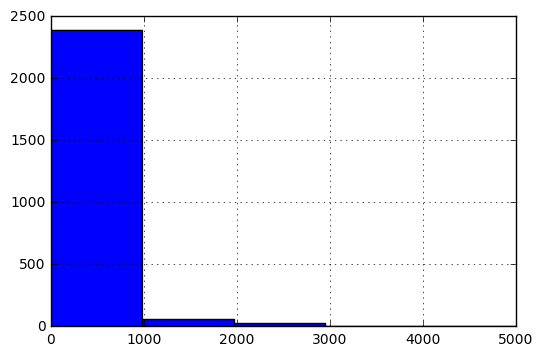

In [13]:
sorted_predictions.index = range(1,len(sorted_predictions) + 1)
plt.figure()
#plt.plot(sorted_predictions.index, sorted_predictions.values)
plot = sorted_predictions.hist(bins=30)
plot.set_xlim([0,5000])
plt.show

In [14]:
sorted_predictions.columns = ["Prediction"]
sorted_predictions = pd.DataFrame(sorted_predictions)
predicted_values = sorted_predictions
predicted_values["Prediction"] = np.where(predicted_values["Prediction"] >= 500, 1, 0)
predicted_values["Prediction"].value_counts()

0    2218
1     289
Name: Prediction, dtype: int64

In [15]:
accuracy_score(true_values, predicted_values)

0.22816114878340646

In [16]:
confusion_matrix(true_values, predicted_values)

array([[ 312,   29],
       [1906,  260]])